In [1]:
#pySnowRadar modules
import sys
%matplotlib inline

# from pySnowRadar import SnowRadar
# from pySnowRadar.processing import extract_layers
# from pySnowRadar.algorithms import Wavelet_TN, Peakiness

from msc_thesis_functions import *
del sys.modules['msc_thesis_functions']
from msc_thesis_functions import *
import pickle

#Community packages
import os
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks
from datetime import datetime, timedelta
from thefuzz import process, fuzz
from scipy.spatial.distance import cdist
from tqdm import tqdm
import h5py
import cmasher as cmr
import xarray as xr
from scipy.stats import linregress
import matplotlib.colors as mcolors
from pyproj import Transformer
from shapely.geometry import Polygon, Point, MultiPoint, LineString
from shapely import affinity

import numpy as np
import shapely
import seaborn as sns
from pyproj import Transformer
transformer = Transformer.from_crs(4326, 3413, always_xy=True)


pd.options.mode.chained_assignment = None  # default='warn'

from matplotlib.colors import LinearSegmentedColormap

ncolors = 256
color_array = plt.get_cmap('Blues')(range(ncolors))
color_array[:,-1] = np.linspace(0.2,1,ncolors)
map_object = LinearSegmentedColormap.from_list(name='Blues_alpha',colors=color_array)
# 
# register this new colormap with matplotlib
# plt.colormaps.register(cmap=map_object)

from pyproj import Transformer
transformer = Transformer.from_crs(4326, 3413, always_xy=True)

from scipy.constants import speed_of_light


import matplotlib.font_manager as font_manager

font_path= '/Users/torka/Library/Fonts/FiraSans-Light.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

import geopandas as gpd

In [8]:
outer_path = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/Peakiness_tuning'
site = 'grid3'

folder_names = []
for log_peak_threshold in [0.4, 0.5, 0.6, 0.7, 0.8]:
        for lin_peak_threshold in [0.2, 0.3, 0.4, 0.5]:
            for pp_r_threshold in [20, 25, 30, 35]:
                for pp_l_threshold in [20, 25, 30, 35]:
                    fname = os.path.join(outer_path, site,str(log_peak_threshold) + '_' + str(lin_peak_threshold) + '_' + str(pp_r_threshold) + '_' + str(pp_l_threshold))
                    folder_names.append(fname)

In [25]:
def match_to_MP(df_tmp, MP_data, ATM_data):
    
    xx, yy = np.meshgrid(MP_data['easting'], MP_data['northing'], indexing='xy')
    zz_ATM = MP_data['snow_depth'].values.flatten()

    mask = ~np.isnan(zz_ATM)
    xx = xx.flatten()[mask]
    yy = yy.flatten()[mask]

    poly_points_indices_wavelet = points_in_poly_list(df_tmp['footprints'], list(zip(xx, yy)), 10)
    wavelet_indices = list(poly_points_indices_wavelet.keys())
    df_tmp = df_tmp.loc[wavelet_indices] #delete not fully-covered footprints
    df_tmp['grid_indices'] = poly_points_indices_wavelet
    df_tmp['MP_snow_depth'] = df_tmp['grid_indices'].apply(lambda x: MP_data['snow_depth'].values.flatten()[mask][x])
    df_tmp['MP_snow_depth_uncertainty'] = df_tmp['grid_indices'].apply(lambda x: MP_data['snow_depth_uncertainty'].values.flatten()[mask][x])
    df_tmp['ATM_elev'] = df_tmp['grid_indices'].apply(lambda x: ATM_data['elevation'].values.flatten()[mask][x])
     
    offset = np.mean(df_tmp['ATM_elev'].apply(lambda x: np.nanmean(x)) - df_tmp['air_snow_elevation'])
    
    df_tmp['ATM_elev_offset'] = df_tmp['ATM_elev'].apply(lambda x: x-offset)
    
    df_lookup = pd.DataFrame({'indices':wavelet_indices,
                              'MP_snow_depth':df_tmp['grid_indices'].apply(lambda x: MP_data['snow_depth'].values.flatten()[mask][x]),
                              'MP_snow_depth_uncertainty':df_tmp['grid_indices'].apply(lambda x: MP_data['snow_depth_uncertainty'].values.flatten()[mask][x]),
                              'ATM_elev':df_tmp['grid_indices'].apply(lambda x: ATM_data['elevation'].values.flatten()[mask][x]),
                              'ATM_elev_offset':df_tmp['ATM_elev_offset']
                              
                              })
    return df_tmp, df_lookup


def match_to_MP_lookup(df_tmp, df_lookup):
    df_tmp = df_tmp.loc[df_lookup['indices']]
    df_tmp['MP_snow_depth'] = df_lookup['MP_snow_depth']
    df_tmp['MP_snow_depth_uncertainty'] = df_lookup['MP_snow_depth_uncertainty']
    
    df_tmp['ATM_elev'] = df_lookup['ATM_elev']
    df_tmp['ATM_elev_offset'] = df_lookup['ATM_elev_offset']
    return df_tmp

In [26]:
path_MP = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/krigging_onATMgrid_v5_exactTrue'
files = os.listdir(path_MP)
files = [f for f in files if f.endswith('.nc')] 
file = [x for x in files if x.split('_')[1] == str(site)][0]
MP_data = xr.open_dataset(os.path.join(path_MP, file))

path_ATM= '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/ATM_gridded/gridding_v7'
files = os.listdir(path_ATM)
file = [x for x in files if x.split('_')[-1].split('.')[0] == str(site)][0]
ATM_data = xr.open_dataset(os.path.join(path_ATM, file))

footprint_mode = 'pulse_limited_unfocused'

SR_peakiness_dict = {}
footprints_dict = {}
for folder in tqdm(folder_names):
    for file in os.listdir(folder):
        if file.endswith('.nc'):
            ds = xr.open_dataset(os.path.join(folder, file))
            df_tmp = ds.to_dataframe().loc[0]
            df_tmp.reset_index(inplace=True)
            
            if folder == folder_names[0]:   
                df_tmp, sr_footprints = construct_footprints_theoretical(df_tmp, ds, mode=footprint_mode)
                df_tmp['footprints'] = sr_footprints
                
                df_tmp, df_lookup = match_to_MP(df_tmp, MP_data, ATM_data)
                footprints_dict[file] = df_lookup
     
            else:
                df_tmp = match_to_MP_lookup(df_tmp, footprints_dict[file])
                
            if file == os.listdir(folder)[0]:
                df_full = df_tmp
            else:
                df_full = pd.concat([df_full, df_tmp], axis=0)
                
    SR_peakiness_dict[folder.split('/')[-1]] = df_full.reset_index(drop=True)  


100%|██████████| 320/320 [04:22<00:00,  1.22it/s]


WRITING

In [ ]:
output_path = f'/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/Peakiness_tuning/{site}'
for key in tqdm(SR_peakiness_dict.keys()):
    df = SR_peakiness_dict[key]
    df.to_csv(os.path.join(outer_path, key + '.csv'))

READING

In [15]:
output_path = f'/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/Peakiness_tuning/{site}'
files = os.listdir(output_path)
files = np.sort([f for f in files if f.endswith('.csv')])

SR_peakiness_dict = {}
for f in tqdm(files):
    df = pd.read_csv(os.path.join(output_path, f))
    SR_peakiness_dict[f] = df

### SNOW DEPTH comparison

In [23]:
correlations = np.zeros((5,4,4,4))
ns = np.zeros((5,4,4,4))
indices = np.zeros((5,4,4,4))
ind = 0
keys = list(SR_peakiness_dict.keys())
lens = []
for i, log_peak_threshold in enumerate([0.4, 0.5, 0.6, 0.7, 0.8]):
    
    for j, lin_peak_threshold in enumerate([0.2, 0.3, 0.4, 0.5]):

        for k, pp_r_threshold in enumerate([20, 25, 30, 35]):
            
                for l, pp_l_threshold in enumerate([20, 25, 30, 35]):
                    
                    key = keys[ind]
                    x = SR_peakiness_dict[key]['MP_snow_depth'].apply(lambda x: np.nanmean(x))
                    y = SR_peakiness_dict[key]['snow_depth']
                    lens.append(len(y))
                    mask = ~np.isnan(x) & ~np.isnan(y)
                    x = x[mask]
                    y = y[mask]
                    linr = linregress(x,y)
                    correlations[i,j,k,l] = linr.rvalue
                    ns[i,j,k,l] = len(x)
                    indices[i,j,k,l] = ind
                    
                    ind+=1

lens = np.mean(lens)                   
# indices = np.flip(indices, axis=0)
# correlations = np.flip(correlations, axis=0)
# ns = np.flip(ns, axis=0)

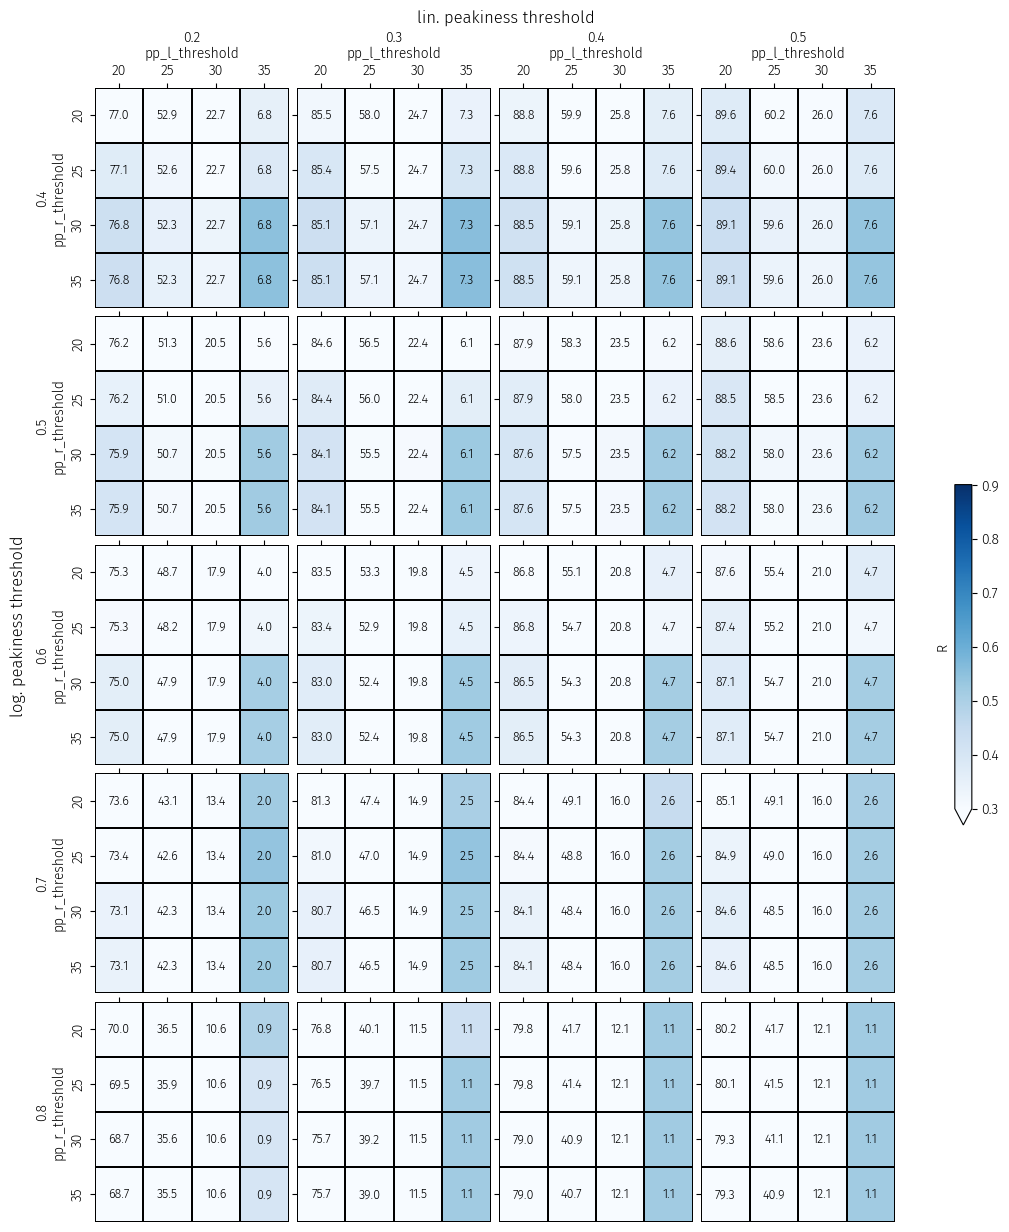

In [24]:
fontsize_norm = mcolors.Normalize(vmin=0, vmax=1)

fig, ax = plt.subplots(5,4, constrained_layout=True, figsize=(10,12))
ax = ax.ravel()
ind = 0

for i in range(5):
    for j in range(4):

        # ax[ind].imshow(cmap[corr_norm(correlations[i,j,:,:]), n_norm(ns[i,j,:,:])])
        
        # for k in range(4):
        #     for l in range(4):
        #         ax[ind].text(l, k, f'{correlations[i,j,k,l]:.2f}\n{ns[i,j,k,l]:.0f}', ha='center', va='center', color='black', fontsize=12)
        sns.heatmap(correlations[i,j,:,:],
                    ax=ax[ind],
                    annot=False,
                    cbar=False,
                    cmap='Blues',
                    linecolor='black',
                    linewidths=.05,
                    vmax=0.9,
                    vmin=0.3,
                    # alpha=.5
                    )
        
        sns.heatmap(ns[i,j,:,:].astype(int) / lens * 100,
                    ax=ax[ind],
                    annot=True,
                    annot_kws={'color':'black', 'fontsize':9},
                    cbar=False,
                    fmt='.1f',
                    alpha=0
                    )
        
        ind+=1
        
for i in range(len(ax)):
    ax[i].set_xticks([0.5, 1.5, 2.5, 3.5])
    ax[i].set_yticks([0.5, 1.5, 2.5, 3.5])
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].xaxis.tick_top()

    # ax[i].invert_yaxis()

ax[0].set_xlabel(f'{[0.2, 0.3, 0.4, 0.5][0]}\npp_l_threshold')
ax[1].set_xlabel(f'{[0.2, 0.3, 0.4, 0.5][1]}\npp_l_threshold')
ax[2].set_xlabel(f'{[0.2, 0.3, 0.4, 0.5][2]}\npp_l_threshold')
ax[3].set_xlabel(f'{[0.2, 0.3, 0.4, 0.5][3]}\npp_l_threshold')

ax[0].xaxis.set_label_position('top') 
ax[1].xaxis.set_label_position('top') 
ax[2].xaxis.set_label_position('top') 
ax[3].xaxis.set_label_position('top') 

ax[0].set_xticklabels([20, 25, 30, 35])
ax[1].set_xticklabels([20, 25, 30, 35])
ax[2].set_xticklabels([20, 25, 30, 35])
ax[3].set_xticklabels([20, 25, 30, 35])

ax[0].set_ylabel(f'{[0.4, 0.5, 0.6, 0.7, 0.8][0]}\npp_r_threshold')
ax[4].set_ylabel(f'{[0.4, 0.5, 0.6, 0.7, 0.8][1]}\npp_r_threshold')
ax[8].set_ylabel(f'{[0.4, 0.5, 0.6, 0.7, 0.8][2]}\npp_r_threshold')
ax[12].set_ylabel(f'{[0.4, 0.5, 0.6, 0.7, 0.8][3]}\npp_r_threshold')
ax[16].set_ylabel(f'{[0.4, 0.5, 0.6, 0.7, 0.8][4]}\npp_r_threshold')

ax[0].set_yticklabels([20, 25, 30, 35])
ax[4].set_yticklabels([20, 25, 30, 35])
ax[8].set_yticklabels([20, 25, 30, 35])
ax[12].set_yticklabels([20, 25, 30, 35])
ax[16].set_yticklabels([20, 25, 30, 35])

fig.supxlabel('lin. peakiness threshold', y=1)
fig.supylabel('log. peakiness threshold')

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=mcolors.Normalize(0.3,0.9),cmap='Blues'),
             ax=ax, orientation='vertical', label='R', shrink=.3, extend='min')

cbar.ax.yaxis.set_label_position('left')

### A|S COMPARISON

In [52]:
correlations = np.zeros((5,4,4,4))
ns = np.zeros((5,4,4,4))
indices = np.zeros((5,4,4,4))
rmses = np.zeros((5,4,4,4))

ind = 0
keys = list(SR_peakiness_dict.keys())
lens = []
for i, log_peak_threshold in enumerate([0.4, 0.5, 0.6, 0.7, 0.8]):
    
    for j, lin_peak_threshold in enumerate([0.2, 0.3, 0.4, 0.5]):

        for k, pp_r_threshold in enumerate([20, 25, 30, 35]):
            
                for l, pp_l_threshold in enumerate([20, 25, 30, 35]):
                    
                    key = keys[ind]
                    x = SR_peakiness_dict[key]['ATM_elev_offset'].apply(lambda x: np.nanmean(x))
                    y = SR_peakiness_dict[key]['air_snow_elevation']
                    mask = ~np.isnan(x) & ~np.isnan(y)
                    x = x[mask]
                    y = y[mask]
                    lens.append(len(y))
                    
                    linr = linregress(x,y)
                    correlations[i,j,k,l] = linr.rvalue
                    rmses[i,j,k,l] = linr.stderr
                    ns[i,j,k,l] = len(x)
                    indices[i,j,k,l] = ind
                    
                    ind+=1

lens = np.mean(lens)                   
# indices = np.flip(indices, axis=0)
# correlations = np.flip(correlations, axis=0)
# ns = np.flip(ns, axis=0)

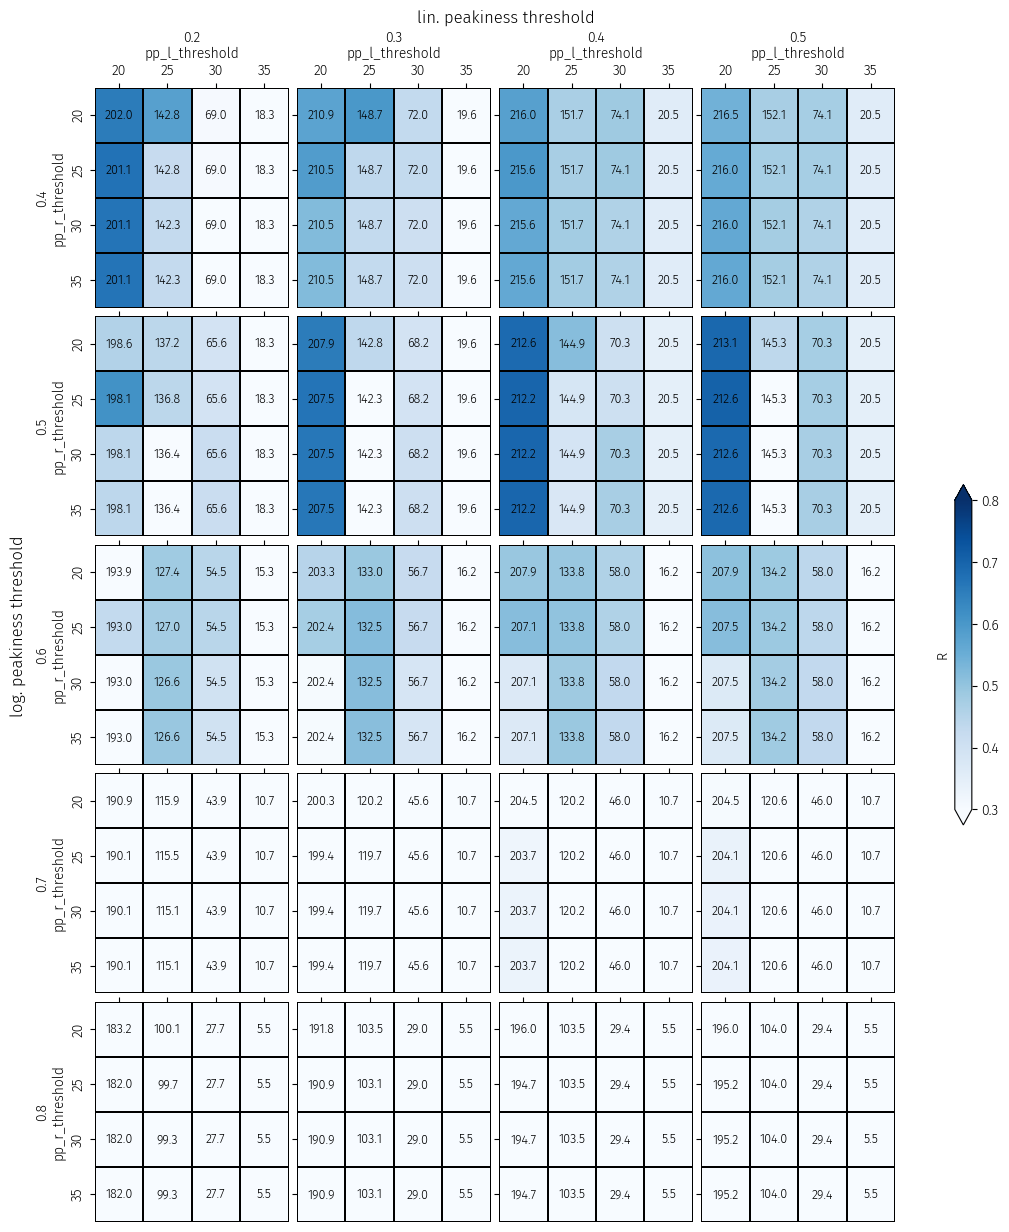

In [60]:

fig, ax = plt.subplots(5,4, constrained_layout=True, figsize=(10,12))
ax = ax.ravel()
ind = 0

for i in range(5):
    for j in range(4):

        # ax[ind].imshow(cmap[corr_norm(correlations[i,j,:,:]), n_norm(ns[i,j,:,:])])
        
        # for k in range(4):
        #     for l in range(4):
        #         ax[ind].text(l, k, f'{correlations[i,j,k,l]:.2f}\n{ns[i,j,k,l]:.0f}', ha='center', va='center', color='black', fontsize=12)
        sns.heatmap(correlations[i,j,:,:],
                    ax=ax[ind],
                    annot=False,
                    cbar=False,
                    cmap='Blues',
                    linecolor='black',
                    linewidths=.05,
                    vmax=0.8,
                    vmin=0.3,
                    # alpha=.5
                    )
        
        sns.heatmap(ns[i,j,:,:].astype(int) / lens * 100,
                    ax=ax[ind],
                    annot=True,
                    annot_kws={'color':'black', 'fontsize':9},
                    cbar=False,
                    fmt='.1f',
                    alpha=0
                    )
        
        ind+=1
        
for i in range(len(ax)):
    ax[i].set_xticks([0.5, 1.5, 2.5, 3.5])
    ax[i].set_yticks([0.5, 1.5, 2.5, 3.5])
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].xaxis.tick_top()

    # ax[i].invert_yaxis()

ax[0].set_xlabel(f'{[0.2, 0.3, 0.4, 0.5][0]}\npp_l_threshold')
ax[1].set_xlabel(f'{[0.2, 0.3, 0.4, 0.5][1]}\npp_l_threshold')
ax[2].set_xlabel(f'{[0.2, 0.3, 0.4, 0.5][2]}\npp_l_threshold')
ax[3].set_xlabel(f'{[0.2, 0.3, 0.4, 0.5][3]}\npp_l_threshold')

ax[0].xaxis.set_label_position('top') 
ax[1].xaxis.set_label_position('top') 
ax[2].xaxis.set_label_position('top') 
ax[3].xaxis.set_label_position('top') 

ax[0].set_xticklabels([20, 25, 30, 35])
ax[1].set_xticklabels([20, 25, 30, 35])
ax[2].set_xticklabels([20, 25, 30, 35])
ax[3].set_xticklabels([20, 25, 30, 35])

ax[0].set_ylabel(f'{[0.4, 0.5, 0.6, 0.7, 0.8][0]}\npp_r_threshold')
ax[4].set_ylabel(f'{[0.4, 0.5, 0.6, 0.7, 0.8][1]}\npp_r_threshold')
ax[8].set_ylabel(f'{[0.4, 0.5, 0.6, 0.7, 0.8][2]}\npp_r_threshold')
ax[12].set_ylabel(f'{[0.4, 0.5, 0.6, 0.7, 0.8][3]}\npp_r_threshold')
ax[16].set_ylabel(f'{[0.4, 0.5, 0.6, 0.7, 0.8][4]}\npp_r_threshold')

ax[0].set_yticklabels([20, 25, 30, 35])
ax[4].set_yticklabels([20, 25, 30, 35])
ax[8].set_yticklabels([20, 25, 30, 35])
ax[12].set_yticklabels([20, 25, 30, 35])
ax[16].set_yticklabels([20, 25, 30, 35])

fig.supxlabel('lin. peakiness threshold', y=1)
fig.supylabel('log. peakiness threshold')

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=mcolors.Normalize(0.3,0.8),cmap='Blues'),
             ax=ax, orientation='vertical', label='R', shrink=.3, extend='both')

cbar.ax.yaxis.set_label_position('left')

Text(0, 0.5, 'PEAK air-snow elevation [m]')

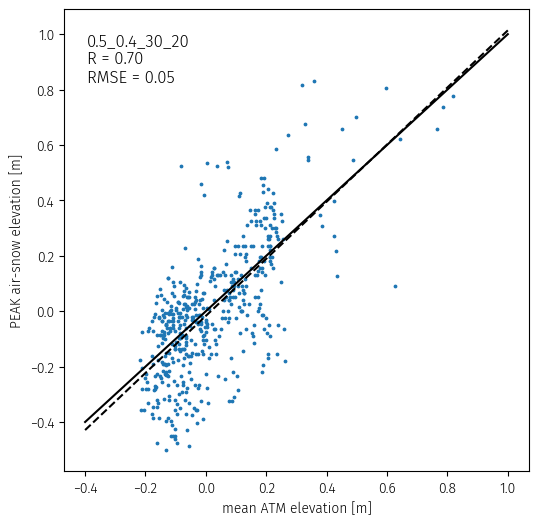

In [72]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
xs = np.linspace(-.4, 1, 100)
key = '0.5_0.4_30_20'
# df = SR_peakiness_dict[key]
x = SR_peakiness_dict[key]['ATM_elev_offset'].apply(lambda x: np.nanmean(x))
y = SR_peakiness_dict[key]['air_snow_elevation']
mask = ~np.isnan(x) & ~np.isnan(y)
x = x[mask]
y = y[mask]
linr = linregress(x,y)
ax.text(0.05, 0.95, f'{key}\nR = {linr.rvalue:.2f}\nRMSE = {linr.stderr:.2f}', ha='left', va='top', transform=ax.transAxes, fontsize=12)
ax.plot(xs, linr.slope*xs + linr.intercept, color='black', linestyle='--')
ax.plot([-0.4, 1], [-0.4, 1], color='black', linestyle='-')    
ax.scatter(x, y, s=3)
# ax[0].scatter(df['x'], df['y'])

ax.set_xlabel('mean ATM elevation [m]')
ax.set_ylabel('PEAK air-snow elevation [m]')